::: {.hidden}
$$
\newcommand{\R}{\mathbb{R}}
\newcommand{\vx}{\mathbf{x}}
\newcommand{\vy}{\mathbf{y}}
\newcommand{\vz}{\mathbf{z}}
\newcommand{\mX}{\mathbf{X}}
\newcommand{\vw}{\mathbf{w}}
\newcommand{\bracket}[1]{\langle #1 \rangle}
\newcommand{\paren}[1]{\left( #1 \right)}
\newcommand{\one}[1]{\mathbb{1}\left[ #1 \right]}
\newcommand{\cL}{\mathcal{L}}
\newcommand{\cD}{\mathcal{D}}
\newcommand{\cM}{\mathcal{M}}
\newcommand{\mA}{\mathbf{A}}
\newcommand{\vtheta}{\boldsymbol{\theta}}
\newcommand{\norm}[1]{\lVert #1 \rVert}
\newcommand{\prob}[1]{\mathbb{P}\left[#1\right]}
\newcommand{\E}{\mathbb{E}}

\usepackage{amsmath}
\DeclareMathOperator*{\argmax}{arg\,max}
\DeclareMathOperator*{\argmin}{arg\,min}
$$

:::

## Quick Recap

Last time, we introduced the *empirical risk minimization* framework for prediction problems. Recall that empirical risk minimization is an approach to supervised learning (which is just another way to say "prediction"). In the supervised learning setup, we have *data*, a pair $(\mX, \vy)$ where 

- $\mX \in \R^{n\times p}$ is the *feature matrix*. There are $n$ distinct observations, encoded as rows. Each of the $p$ columns corresponds to a *feature*: something about each observation that we can measure or infer. Each observation is written $\vx_1, \vx_2,\ldots$. 
$$
\mX = \left[\begin{matrix} & - & \vx_1 & - \\ 
& - & \vx_2 & - \\ 
& \vdots & \vdots & \vdots \\ 
& - & \vx_{n} & - \end{matrix}\right]
$$
- $\vy \in \R^{n}$ is the *target vector*. The target vector gives a label, value, or outcome for each observation. 

What we want to do is find a function $f$ such that $f(\vx) \approx y$ "most of the time." In the empirical risk minimization framework, we approach this task by choosing: 

- A family $\cM$ of predictor functions $f_\vtheta$ that generates predictions $\hat{y} = f_\vtheta(\vx)$. 
- A loss function $\ell$ that compares the prediction and the real value $\ell(\hat{y}, y)$. 
- An algorithm for minimizing the empirical risk 
$$
\hat{R}(f_\vtheta) = \frac{1}{n} \sum_{i = 1}^n \ell(f_\vtheta(\vx_i), y_i)
$${#eq-empirical-risk}
with respect to the parameters $\vtheta$ of $\cM$. 

So far, we've been exclusively considering linear models: $\vtheta = (\vw, b)$ and $f_{\vw, b}(\vx) = \bracket{\vw, \vx} - b$. So, we can write our minimization problem as: 

$$
(\hat{\vw}, \hat{b}) = \argmin_{\vw, b} \frac{1}{n} \sum_{i = 1}^n \ell(\bracket{\vw, \vx_i} - b, y_i)\;.
$$ {#eq-empirical-risk-linear}

## Some Questions For Empirical Risk Minimization

It is at this point that we need to ask some important questions with awkward answers. 

1. **Existence**: Does @eq-empirical-risk-linear have *any* solutions? 
2. **Uniqueness**: Assuming there exists a solution to @eq-empirical-risk-linear, is it unique? Or are there many different solutions? 
3. **Searchability**: Is it possible to write algorithms are guaranteed to find a solution of @eq-empirical-risk-linear? 
4. **Performance**: Is it possible to make these algorithms *fast*?  

In most prediction problems, what we'd really like is to be *right* about the true value of $y$. In the context of linear classifiers, this means that we want all the points of one label to be on one side of the line, and all the points of the other label to be on the other side. The loss function that expresses this idea is the 0-1 loss: 
$$
\ell(\hat{y}, y) = 1 - \one{\hat{y}y > 0}\;.
$$
When we graph the 0-1 loss, it looks like this. I've shown versions corresponding to both $y = 1$ and $y = -1$. 

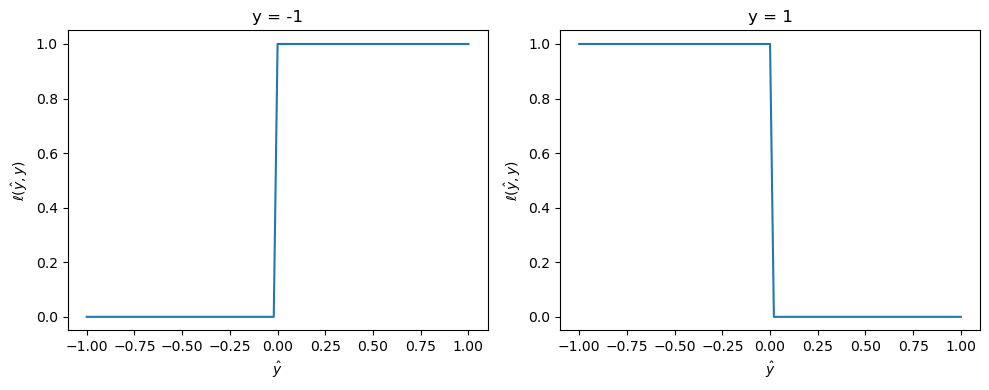

In [15]:
from matplotlib import pyplot as plt 
import numpy as np

plt.rcParams["figure.figsize"] = (10, 4)

fig, axarr = plt.subplots(1, 2) 
y_hat = np.linspace(-1, 1, 101)

loss = lambda y_hat, y: 1 - 1*(y_hat*y > 0)

for j in range(2):
    y = [-1, 1][j]
    axarr[j].set_title(f"y = {y}")
    axarr[j].set(xlabel = r"$\hat{y}$", 
                 ylabel = r"$\ell(\hat{y}, y)$")
    
    axarr[j].plot(y_hat, loss(y_hat, y))

plt.tight_layout()

Let's now ask our four questions of the 0-1 loss. 

**Existence**: Does @eq-empirical-risk-linear have *any* solutions? 

- We are good on this one! Specifically, the risk can take on only a finite number of possible values (values between 0 and 1 in increments of $1/n$). In any given problem there is a smallest such value obtained, and this is a solution. 

**Uniqueness**: Assuming there exists a solution to @eq-empirical-risk-linear, is it unique? Or are there many different solutions? 

[To definte "usually" and "just a little bit" rigorously, we need to specify a data generating distribution and do some math.]{.aside}

- Unfortunately, the solution to @eq-empirical-risk-linear for the 0-1 loss is almost never unique. This is because, if you have one solution $(\vw, b)$, you can "usually" jiggle it by "just a little bit" and still have a minimizing solution. 

- **Searchability**: Is it possible to write algorithms are guaranteed to find a solution of @eq-empirical-risk-linear? 

Technically, we could just try a very large number of choices of $(\vw, b)$ and hope for the best, but that's not very efficient (in fact, the problem of getting a reasonable answer this way is exponential in $d$, the number of features). Can we do better? 

4. **Performance**: Is it possible to make these algorithms *fast*?  

This is where our real problem lies: 

::: {.callout-tip} 

::: {#thm-perceptron-np-hard}

## 0-1 Minimization for Linear Classifiers is NP Hard (@kearns1994toward)

Unless P = NP, there is no polynomial-time algorithm that can solve the 0-1 empirical risk minimization problem for linear classifiers. 

:::
:::

So, if we are going to have reasonable algorithms for empirical risk minimization, *we need to choose a different loss function*. There are multiple choices. Before we jump into examples, we're going to define the core mathematical concept that is going to help address our core questions of existence, uniqueness, searchability, and performance. 

## Convexity

::: {.callout-note}
::: {#def-convex-set} 

A set $S \subseteq \R^n$ is *convex* if, for any two points $\vz_1, \vz_2 \in S$ and for any $\lambda \in [0,1]$, the point $\vz = \lambda \vz_1 + (1-\lambda) \vz_2$ is also an element of $S$. 

::: 
:::


::: {.callout-note}
::: {#def-convex-function} 

## Convex Functions

Let $S \subseteq \R^n$ be convex. A function $f:S \rightarrow \R$ is *convex* if, for any $\lambda \in \R$ and any two points $\vz_1, \vz_2 \in S$, we have 

$$
f(\lambda \vz_1 + (1-\lambda)\vz_2) \leq \lambda f( \vz_1 ) + (1-\lambda)f(\vz_2)\;.
$$

The function $f$ is *strictly convex* if the inequality is strict: for all $\lambda$, $\vz_1$, and $\vz_2$, 

$$
f(\lambda \vz_1 + (1-\lambda)\vz_2) < \lambda f( \vz_1 ) + (1-\lambda)f(\vz_2)\;.
$$

:::
:::

Roughly, a convex function is "bowl-shaped." 

::: {.callout-note} 
::: {#def-minima} 

## Local and Global Minima
 
A point $\vz\in S$ is a *global minimum* of the function $f:S \rightarrow \R$ if $f(\vz) \leq f(\vz')$ for all $\vz' \in S$. 

A point $\vz \in S$ is a *local minimum* of $f:S \rightarrow \R$ if there exists a neighborhood $T \subseteq S$ containing $\vz$ such that $\vz$ is a global minimum of $f$ on $T$. 

:::
:::




[It's ok if you don't know what it means for a set to be closed -- all the convex functions we will care about in this class will either be defined on sets where this theorem holds or will be otherwise defined so that the conclusions apply. 
]{.aside}

::: {.callout-note} 
::: {#thm-convex-functions-are-nice}

Let $f:S \rightarrow \R$ be a convex function. Then: 

1. If $S$ is closed and bounded, $f$ achieves a minimum $\vz^*$ on $S$. 
2. Furthermore, if $\vz^*$ is a *local* minimum of $f$, then it is also a global minimum. 
2. If in addition $f$ is *strictly* convex, then this minimum is unique. 

:::
::: 

::: {.proof} 
The proof of item 1 needs some tools from real analysis. The short version is: 

- Every convex function is *continuous*. 
- If $S\subseteq \R^n$ is closed and bounded, then it is *compact*. 
- Continuous functions achieve minima and maxima on compact sets. 

It's ok if you didn't follow this! Fortunately the second part of the proof is one we can do together. Suppose to contradiction that $\vz^*$ is a local minimum of $f$, but that there is also a point $\vz'$ such that $f(\vz') < f(\vz^*)$. Since $\vz^*$ is a local minimum, we can find some neighborhood $T$ containing $\vz^*$ such that $\vz^*$ is a minimum of $f$ on $T$. Let $\lambda$ be some very small number and consider the point $\vz = \lambda \vz' + (1-\lambda)\vz^*$. Specifically, choose $\lambda$ small enough so that $\vz \in T$ (since this makes $\vz$ close to $\vz^*$). We can evaluate 

$$
\begin{align}
f(\vz) &= f(\lambda \vz' + (1-\lambda)\vz^*) \tag{definition of $\vz$}\\ 
       &\leq \lambda f(\vz') + (1-\lambda)f(\vz^*)  \tag{$f$ is convex} \\ 
       &= f(\vz^*) + \lambda (f(\vz') - f(\vz^*)) \tag{algebra}\\ 
       &< f(\vz^*)\;. \tag{assumption that $f(\vz') < f(\vz^*)$}
\end{align}
$$

But this is a contradiction, since we constructed $\vz$ to be in the neighborhood $T$ where $\vz^*$ is a local minimum. We conclude that there is no  $\vz'$ such that $f(\vz') < f(\vz^*)$, and therefore that $\vz^*$ is a global minimum. 

The proof of the third part follows a very similar argument to the proof of the second part! 
:::

There's two other very important math facts that we need in order to apply convexity to the empirical risk minimization problem for linear models. 

[By induction, it follows that any linear combination of convex functions with positive coefficients is convex.]{.aside}

::: {.callout-note}

::: {#thm-convex-compositions} 

1. Let $f_1$ and $f_2$ be convex functions with the same domain, and let $a$ and $b$ be nonnegative real numbers. Then, the function $f$ defined by $f(\vz) = af_1(\vz) + bf_2(\vz)$ is also convex. 
2. Let $f:\R^n\rightarrow \R$ be convex. Let $\mA \in \R^{n\times p}$ and $\mathbf{b} \in \R^n$. Then, the function $f_\mA$ defined by $f_{\mA,\mathbf{b}}(\vz) = f(\mA\vz - \mathbf{b})$ is convex.   
:::
:::

## Convexity and Empirical Risk Minimization 

Let's finally go back to the empirical risk minimization problem for linear models: 

$$
(\hat{\vw}, \hat{b}) = \argmin_{\vw, b} \frac{1}{n} \sum_{i = 1}^n \ell(\bracket{\vw, \vx_i} - b, y_i)\;.
$$ {#eq-empirical-risk-linear}

Let's now assume that the loss function $\ell$ is strictly convex in its first argument: that is, for any possible value of $y$ and any $\lambda \in [0,1]$, 
$$
\ell(\lambda \hat{y}_1 + (1-\lambda)\hat{y}, y) \leq  \lambda \ell(\hat{y}_1, y) + (1-\lambda)\ell(\hat{y}, y)\;. 
$$
Then, suddenly the following things would all also be true: 

1. $\ell(\bracket{\vw, \vx} - b, y)$ is strictly convex as a function of $\vw$ and $b$ (@thm-convex-compositions, part 2). 
2. The empirical risk $R(\vw, b) = \frac{1}{n}\sum_{i = 1}^n \ell(\bracket{\vw, \vx_i} - b, y_i)$ is strictly convex as a function of $\vw$ and $b$ (@thm-convex-compositions, part 1). 
3. If the empirical risk $R(\vw, b)$ has a global minimum, that global minimum is unique (@thm-convex-functions-are-nice, part 3). 
4. The empirical risk $R(\vw, b)$ has no local minima which are not global minima. 

These facts have important implications for our fundamental questions on empirical risk minimization. 

**Existence**. Even convex functions are not guaranteed to have minima. However, there are lots of choices of loss function $\ell$ which are sufficient go guarantee that the empirical risk has a minimizer. 

**Uniqueness**: When the empirical risk is strictly convex, there can only be one global minimizer. 

**Searchability**: When the empirical risk is strictly convex, there are also no local minima other than the global minimum. Algorithmically, ***this is the most important property of convexity***. It means that if I manage to find any local minimum at all, that point *must* be the global minimum. 

**Performance**: Convexity significantly reduces the difficulty of our task: instead of trying to find "the best" solution, it's sufficient for us to find any local optimum. This means that we can design our algorithms to be "local optimum hunters." There are lots of fast algorithms to do this. An especially important class of algorithms are *gradient descent methods*, which we'll discuss soon. 


## Demo: Logistic Regression

Let's do a partial implementation of logistic regression to illustrate these techniques. In logistic regression, our loss function is the logistic loss 

$$
\ell(\hat{y}, y) = y \log \hat{y} + (1-y)\log (1-\hat{y})\;. 
$$

*The logistic loss is convex*, although proving this requires a little bit of extra math that we haven't discuss. This means that the empirical risk minimization problem can have at most one minimum. In fact, it's possible to show, if the data is *not* linearly separable, there is a unique global maximum. 

Here is some sample data for which we will try to find a good linear classifier. 

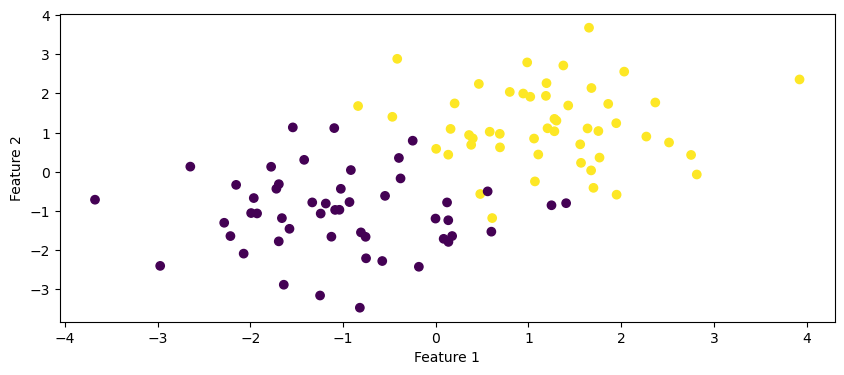

In [76]:
#| fig-cap: Note that this data is **not** linearly separable. The perceptron algorithm wouldn't even have converged for this data set, but logistic regression will do great. 

from sklearn.datasets import make_blobs

p_features = 3

X, y = make_blobs(n_samples = 100, n_features = p_features - 1, centers = [(-1, -1), (1, 1)])

fig = plt.scatter(X[:,0], X[:,1], c = y)
xlab = plt.xlabel("Feature 1")
ylab = plt.ylabel("Feature 2")

Now let's do an implementation. First let's define a linear predictor function of the form $f(\vx) = \bracket{w, \vx} - b$. Note that this predictor makes the predictions on *all* the training data at once! 

In [77]:
import numpy as np 
from scipy.optimize import minimize
np.seterr(all='ignore')

def predict(X, w, b):
    return X@w - b

Now we'll define some functions to compute the empirical risk: 

In [78]:
# these two functions will both work on the entire training data set at once!! 
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# returns a vector containing the per-observation logistic loss for each observation
def logistic_loss(y_hat, y): 
    return y*np.log(sigmoid(y_hat)) + (1-y)*np.log(1-sigmoid(y_hat))

# first compute the predictions, then compute the average loss per observation
def empirical_risk(X, y, w, b, loss):
    y_hat = predict(X, w, b)
    return loss(y_hat, y).mean()

Finally, we can write the function that will solve the empirical risk minimization problem for us. We're going to use the `scipy.optimize.minimize` function, which is a built-in function for solving minimization problems. Soon, we'll study how to solve minimization problems from scratch. 

The `scipy.optimize.minimize` function requires us to pass it a single function that accepts a vector of parameters, plus an initial guess for the parameters. So, we need to do a little bookkeeping in order to keep all our parameters straight. 

In [79]:
def find_pars(X, y):
    
    # define a new version of the empirical risk that accepts a single parameter theta and splits this parameter into w and b before passing it into the risk function
    
    def to_minimize(theta):
        w = theta[:-1]
        b = theta[1]
        return empirical_risk(X, y, w, b, logistic_loss)
    
    p = X.shape[1]
    result = minimize(to_minimize, x0 = np.random.rand(p+1)) 
    
    # get the vector of parameters that minimizes the function 
    theta = result.x
    
    # return the parameters split into w and b
    return theta[:-1], theta[-1]

In [80]:
w, b = find_pars(X, y)
w, b

(array([0.35025174, 0.53460352]), 0.3052924817372483)

Let's plot the linear classifier that we learned! 

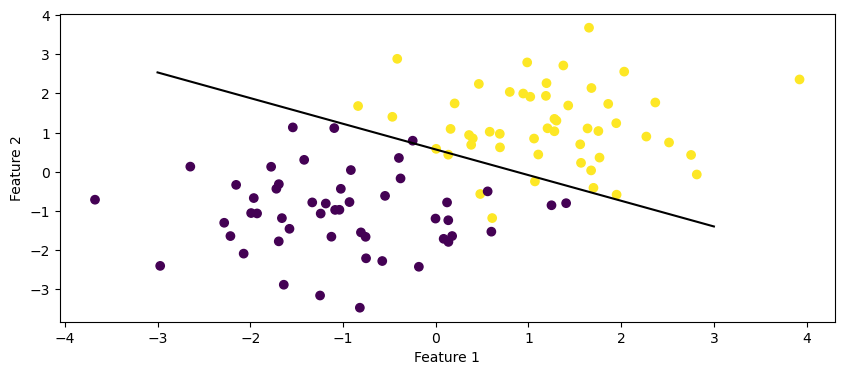

In [81]:
fig = plt.scatter(X[:,0], X[:,1], c = y)
xlab = plt.xlabel("Feature 1")
ylab = plt.ylabel("Feature 2")

f1 = np.linspace(-3, 3, 101)

plt.plot(f1, (b - f1*w[0])/w[1], color = "black")

Since the logistic loss is convex, we are guaranteed that this solution is the unique best solution (as measured by the logistic loss). There is no other possible set of parameters that would lead to a better result (again, as measured by the logistic loss). 